Notebook for Dev Of Main Functions
Complete Script Found in FinalProj.py

Chat history handling

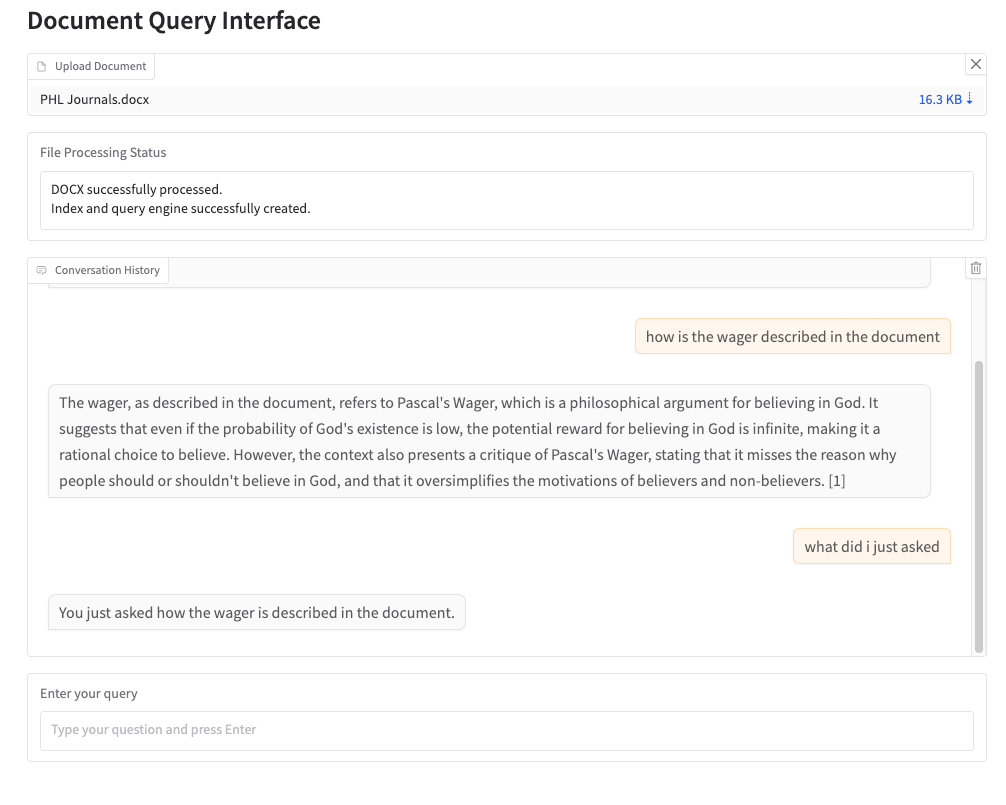

In [64]:
#Manage Imports

#llamaindex stuff
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.agent import ReActAgent
from llama_index.core.schema import IndexNode
from llama_index.core.query_engine import CitationQueryEngine
from llama_index.core import (
    Settings,
    Document,
    SimpleDirectoryReader,
    VectorStoreIndex,
    #SummaryIndex,
)
from llama_index.llms.groq import Groq
#Document Readers
import ebooklib
from bs4 import BeautifulSoup
from ebooklib import epub

#Initalize LLM and Embedding Model

#Using Groq Temporarily due to low computer ram.
import os
from dotenv import load_dotenv
load_dotenv()
llm = Groq(model="llama3-groq-70b-8192-tool-use-preview", api_key=(os.getenv("GROQ_API_KEY")))
#llm = Ollama(model="llama3.2:latest", temperature=0)
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

#Settings the models to be used
Settings.llm = llm
Settings.embed_model = embed_model
#Settings for the chunk size and overlap for efficient embedding at VectorStoreIndex
Settings.chunk_size = 512
Settings.chunk_overlap = 30


debug = True

In [66]:
#Document Processing
file_name = input(" Enter the (enter) file name inside the document directory: ")
document = os.path.expanduser(f'~/Workspace/COS243/LocalLib/documents/{file_name}')#adjusted accordingly

#Ebooks(Text)

if file_name.lower().endswith('.epub'):
    if debug:
        print("Loading Ebook through Epub Reader.")
    book = epub.read_epub(document)
    #Initialize list to store all the text
    all_text = []
    if debug and book.get_metadata('DC', 'title'):
        print(f"Loaded Ebook of Title : {book.get_metadata('DC', 'title')[0][0]}\n\n")
    elif debug: 
        print("Loading Unssuccessful\n\n")

    for item in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
        #Parse it with soup
        soup = BeautifulSoup(item.get_content(), 'html.parser')
        text = soup.get_text()

        all_text.append(text)
    
    #Creating Document Object so it can be embedded
    full_text = [Document(text=t) for t in all_text]
    if debug and full_text:
        print("Converted Document Object\n\n")
    elif debug: 
        print("Convertion Unssuccessful\n\n")

#More efficient document parsing modules can be added in the future

#General Document Loading
else:
    if debug:
        print('Loading Document Object through SimpleDirectoryReader.')
    full_text = SimpleDirectoryReader(input_files=[document]).load_data()
    if debug and full_text[0].metadata:
        print(f"Loaded Document of Title : {full_text[0].metadata['file_name']}\n\n")
    elif debug: 
        print("Loading Unssuccessful\n\n")

Loading Ebook through Epub Reader.
Loaded Ebook of Title : Pride and Prejudice




/Users/yh.z/miniforge3/envs/newenv/lib/python3.10/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
/Users/yh.z/miniforge3/envs/newenv/lib/python3.10/site-packages/ebooklib/epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):


Converted Document Object




In [78]:
#Embedding the Document
vector_index = VectorStoreIndex.from_documents(full_text,show_progress=debug)

#Define Query Engines
vector_query_engine = vector_index.as_query_engine()

# define tools
query_engine_tools = [
    QueryEngineTool(
        query_engine=vector_query_engine,
        metadata=ToolMetadata(
            name="vector_tool",
            description=(
                f"Useful for retrieving information from {file_name}"
            ),
        ),
    ),
]

#Build document specific agent

agent = ReActAgent.from_tools(
    query_engine_tools,
    llm = llm,
    verbose=debug,
)

#Index nodes for future multi-doc module
objects = []

file_summary = (
    "Use this index if you need to lookup specific facts about"
    f" {file_name}."
)

node = IndexNode(
    text=file_summary, index_id=file_name, obj=agent
)
objects.append(node)
node_index = VectorStoreIndex(
    objects=objects,
)
#Force citation
query_engine = CitationQueryEngine.from_args(
    index=node_index,
    similarity_top_k = 4,
    citation_chunk_size=512,
    citation_chunk_overlap=20,
)

Generating embeddings: 100%|██████████| 359/359 [00:21<00:00, 16.44it/s]


In [91]:
response = query_engine.query("what happens in the first chapter")

print("\n\n",response)

> Running step b4c24817-f3f7-4738-b611-01ea2a4ac7d1. Step input: what happens in the first chapter
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool
Action Input: {'input': 'first chapter'}
Observation: Chapter 1
> Running step 4476badf-915c-4bba-8d09-21450d08f54d. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: In the first chapter of Pride and Prejudice, the novel introduces the Bennet family, including the five daughters who are in need of suitable husbands. The arrival of Mr. Bingley, a wealthy young bachelor, sets off a series of events as the family hopes to marry off one of the daughters to him.


 In the first chapter of Pride and Prejudice, the novel introduces the Bennet family, including the five daughters who are in need of suitable husbands. The arrival of Mr. Bingley, a wealthy young bachelor, sets off a series of events as the 